In [22]:
# !unzip ../datasets/MAndMs/Training.zip

In [21]:
# mv ../Different-Data/Training ../datasets/MAndMs/

In [30]:
# !unzip ../datasets/MAndMs/Validation.zip -d ../datasets/MAndMs/

In [29]:
# !unzip ../datasets/MAndMs/Testing.zip -d ../datasets/MAndMs/

In [ ]:
!pip install nibabel==5.3.2+computecanada

In [ ]:
!pip install tqdm==4.67.1+computecanada

In [ ]:
!pip install torch==2.6.0+computecanada

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nib
from tqdm import tqdm
import random
from torch.utils.data import DataLoader, Dataset
import os
import random
import pandas as pd

In [19]:
# ls ../datasets/MAndMs/Training/Labeled/C0K1P0/C0K1P0_sa_gt.nii.gz

In [20]:
# img = load_nifti('../datasets/MAndMs/Training/Labeled/C0K1P0/C0K1P0_sa.nii.gz')
# mask = load_nifti('../datasets/MAndMs/Training/Labeled/C0K1P0/C0K1P0_sa_gt.nii.gz')

In [21]:
# img.shape

In [22]:
# mask.shape

In [34]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
from tqdm import tqdm

def load_nifti(file_path):
    nii = nib.load(file_path)
    return nii.get_fdata()


def extract_End_Diastole_End_Systole_Frames(mask):
    frames = []
    for i in range(mask.shape[-1]):
        if len(np.unique(mask[:,:,:,i])) >1:
            frames.append(i)
    if len(frames) == 2:
        print(f"ED = {frames[0]} ES = {frames[1]}")
        return frames[0], frames[1]
    else:
        return "Wrong", "Wrong"

def extract_2d_slices(volume, slice_axis=2):
    """
    Extract 2D slices along a given axis from a 3D volume.
    """
    slices = []
    for idx in range(volume.shape[slice_axis]):
        slice_2d = volume[:, :, idx] if slice_axis == 2 else volume[idx, :, :]
        slice_2d = np.uint8(np.interp(slice_2d, (slice_2d.min(), slice_2d.max()), (0, 255)))
        img_pil = Image.fromarray(slice_2d)
        slices.append(img_pil)
    return slices

def read_mnms(data_dir, output_dir, data_set,slice_axis=2):
    os.makedirs(output_dir, exist_ok=True)
    patients = [p for p in os.listdir(data_dir) if not p.startswith('.') and os.path.isdir(os.path.join(data_dir, p))]

    for patient_id in tqdm(sorted(patients)):
        patient_dir = os.path.join(data_dir, patient_id)
        image_path = os.path.join(patient_dir, f"{patient_id}_sa.nii.gz")
        mask_path  = os.path.join(patient_dir, f"{patient_id}_sa_gt.nii.gz")

        if not (os.path.exists(image_path) and os.path.exists(mask_path)):
            print(f"Missing files for patient: {patient_id}")
            continue

        print(f"\nProcessing {patient_id}")
        image_vol = load_nifti(image_path)
        mask_vol  = load_nifti(mask_path)
        ed_idx , es_idx = extract_End_Diastole_End_Systole_Frames(mask_vol)

        # Extract time frames
        ed_img, es_img = image_vol[..., ed_idx], image_vol[..., es_idx]
        ed_mask, es_mask = mask_vol[..., ed_idx], mask_vol[..., es_idx]
        
        # print('es mask', np.unique(es_mask))
        # print('ed mask', np.unique(ed_mask))
        
        ed_slices = extract_2d_slices(ed_img, slice_axis)
        es_slices = extract_2d_slices(es_img, slice_axis)
        ed_masks  = extract_2d_slices(ed_mask, slice_axis)
        es_masks  = extract_2d_slices(es_mask, slice_axis)

        # Create output dirs
        for phase in ['ed', 'es']:
            for kind in ['images', 'masks']:
                os.makedirs(f"{output_dir}/{data_set}/{phase}/{kind}", exist_ok=True)

        # Save
        for idx, s in enumerate(ed_slices):
            s.save(f"{output_dir}/{data_set}/ed/images/{patient_id}_slice_{idx}.png")
        for idx, s in enumerate(es_slices):
            s.save(f"{output_dir}/{data_set}/es/images/{patient_id}_slice_{idx}.png")
        for idx, s in enumerate(ed_masks):
            s.save(f"{output_dir}/{data_set}/ed/masks/{patient_id}_slice_{idx}_gt.png")
        for idx, s in enumerate(es_masks):
            s.save(f"{output_dir}/{data_set}/es/masks/{patient_id}_slice_{idx}_gt.png")

    # Summary
    def count(path):
        return len(os.listdir(path)) if os.path.exists(path) else 0

    print("\nSummary:")
    print(f"ED images: {count(f'{output_dir}/{data_set}/ed/images')}")
    print(f"ES images: {count(f'{output_dir}/{data_set}/es/images')}")
    print(f"ED masks:  {count(f'{output_dir}/{data_set}/ed/masks')}")
    print(f"ES masks:  {count(f'{output_dir}/{data_set}/es/masks')}")


In [142]:
read_mnms(
    data_dir='../datasets/MAndMs/Training/Labeled',
    output_dir='../datasets/MAndMs/processed_data/',
    data_set='MAndMs_processed_train_labeled',
)


  0%|                                                                                                                     | 0/150 [00:00<?, ?it/s]


Processing A0S9V9
ED = 0 ES = 9


  1%|▋                                                                                                            | 1/150 [00:01<04:44,  1.91s/it]


Processing A1D0Q7
ED = 0 ES = 9


  1%|█▍                                                                                                           | 2/150 [00:04<05:19,  2.16s/it]


Processing A1D9Z7
ED = 11 ES = 22


  2%|██▏                                                                                                          | 3/150 [00:06<04:52,  1.99s/it]


Processing A1E9Q1
ED = 0 ES = 9


  3%|██▉                                                                                                          | 4/150 [00:07<04:35,  1.89s/it]


Processing A1O8Z3
ED = 10 ES = 23


  3%|███▋                                                                                                         | 5/150 [00:09<04:12,  1.74s/it]


Processing A2C0I1
ED = 0 ES = 7


  4%|████▎                                                                                                        | 6/150 [00:10<04:05,  1.70s/it]


Processing A2N8V0
ED = 0 ES = 9


  5%|█████                                                                                                        | 7/150 [00:12<03:45,  1.57s/it]


Processing A3B7E5
ED = 12 ES = 29


  5%|█████▊                                                                                                       | 8/150 [00:14<04:04,  1.72s/it]


Processing A3H1O5
ED = 0 ES = 12


  6%|██████▌                                                                                                      | 9/150 [00:15<03:44,  1.59s/it]


Processing A4B5U4
ED = 0 ES = 10


  7%|███████▏                                                                                                    | 10/150 [00:17<03:43,  1.59s/it]


Processing A4J4S4
ED = 0 ES = 7


  7%|███████▉                                                                                                    | 11/150 [00:18<03:29,  1.50s/it]


Processing A4U9V5
ED = 0 ES = 8


  8%|████████▋                                                                                                   | 12/150 [00:19<03:16,  1.42s/it]


Processing A5E0T8
ED = 8 ES = 24


  9%|█████████▎                                                                                                  | 13/150 [00:20<03:05,  1.36s/it]


Processing A6B5G9
ED = 0 ES = 11


  9%|██████████                                                                                                  | 14/150 [00:22<02:59,  1.32s/it]


Processing A6D5F9
ED = 0 ES = 11


 10%|██████████▊                                                                                                 | 15/150 [00:23<03:10,  1.41s/it]


Processing A6M1Q7
ED = 11 ES = 29


 11%|███████████▌                                                                                                | 16/150 [00:25<03:31,  1.58s/it]


Processing A7D9L8
ED = 0 ES = 11


 11%|████████████▏                                                                                               | 17/150 [00:26<03:01,  1.36s/it]


Processing A7G0P5
ED = 9 ES = 28


 12%|████████████▉                                                                                               | 18/150 [00:28<03:25,  1.56s/it]


Processing A7M7P8
ED = 0 ES = 9


 13%|█████████████▋                                                                                              | 19/150 [00:29<03:10,  1.45s/it]


Processing A7O4T6
ED = 0 ES = 10


 13%|██████████████▍                                                                                             | 20/150 [00:31<03:01,  1.39s/it]


Processing A8C9U8
ED = 9 ES = 28


 14%|███████████████                                                                                             | 21/150 [00:32<03:21,  1.56s/it]


Processing A8E1F4
ED = 9 ES = 24


 15%|███████████████▊                                                                                            | 22/150 [00:34<03:15,  1.53s/it]


Processing A9C5P4
ED = 8 ES = 29


 15%|████████████████▌                                                                                           | 23/150 [00:36<03:25,  1.62s/it]


Processing A9E3G9
ED = 8 ES = 23


 16%|█████████████████▎                                                                                          | 24/150 [00:37<03:06,  1.48s/it]


Processing A9J5Q7
ED = 7 ES = 24


 17%|██████████████████                                                                                          | 25/150 [00:38<02:48,  1.35s/it]


Processing A9J8W7
ED = 10 ES = 29


 17%|██████████████████▋                                                                                         | 26/150 [00:40<03:12,  1.55s/it]


Processing B0I2Z0
ED = 0 ES = 8


 18%|███████████████████▍                                                                                        | 27/150 [00:41<03:03,  1.49s/it]


Processing B0N3W8
ED = 15 ES = 28


 19%|████████████████████▏                                                                                       | 28/150 [00:43<03:08,  1.54s/it]


Processing B2C2Z7
ED = 0 ES = 8


 19%|████████████████████▉                                                                                       | 29/150 [00:45<03:12,  1.59s/it]


Processing B2D9M2
ED = 0 ES = 8


 20%|█████████████████████▌                                                                                      | 30/150 [00:46<02:55,  1.46s/it]


Processing B2D9O2
ED = 13 ES = 29


 21%|██████████████████████▎                                                                                     | 31/150 [00:48<03:08,  1.59s/it]


Processing B2F4K5
ED = 10 ES = 29


 21%|███████████████████████                                                                                     | 32/150 [00:50<03:29,  1.77s/it]


Processing B2G5R2
ED = 0 ES = 7


 22%|███████████████████████▊                                                                                    | 33/150 [00:51<03:01,  1.55s/it]


Processing B3D0N1
ED = 8 ES = 24


 23%|████████████████████████▍                                                                                   | 34/150 [00:52<02:49,  1.46s/it]


Processing B3O1S0
ED = 0 ES = 8


 23%|█████████████████████████▏                                                                                  | 35/150 [00:53<02:37,  1.37s/it]


Processing B3P3R1
ED = 0 ES = 11


 24%|█████████████████████████▉                                                                                  | 36/150 [00:54<02:16,  1.20s/it]


Processing B4O3V3
ED = 0 ES = 6


 25%|██████████████████████████▋                                                                                 | 37/150 [00:55<02:14,  1.19s/it]


Processing B6D0U7
ED = 9 ES = 29


 25%|███████████████████████████▎                                                                                | 38/150 [00:57<02:39,  1.43s/it]


Processing B8H5H6
ED = 8 ES = 24


 26%|████████████████████████████                                                                                | 39/150 [00:59<02:34,  1.39s/it]


Processing B8J7R4
ED = 0 ES = 12


 27%|████████████████████████████▊                                                                               | 40/150 [01:00<02:32,  1.39s/it]


Processing B9E0Q1
ED = 0 ES = 11


 27%|█████████████████████████████▌                                                                              | 41/150 [01:01<02:34,  1.41s/it]


Processing B9O1Q0
ED = 11 ES = 29


 28%|██████████████████████████████▏                                                                             | 42/150 [01:04<02:57,  1.64s/it]


Processing C0K1P0
ED = 0 ES = 9


 29%|██████████████████████████████▉                                                                             | 43/150 [01:05<02:42,  1.52s/it]


Processing C0S7W0
ED = 7 ES = 24


 29%|███████████████████████████████▋                                                                            | 44/150 [01:06<02:34,  1.46s/it]


Processing C1G5Q0
ED = 8 ES = 24


 30%|████████████████████████████████▍                                                                           | 45/150 [01:07<02:24,  1.38s/it]


Processing C1K8P5
ED = 0 ES = 8


 31%|█████████████████████████████████                                                                           | 46/150 [01:09<02:20,  1.36s/it]


Processing C2J0K3
ED = 0 ES = 9


 31%|█████████████████████████████████▊                                                                          | 47/150 [01:10<02:19,  1.35s/it]


Processing C2L5P7
ED = 12 ES = 28


 32%|██████████████████████████████████▌                                                                         | 48/150 [01:12<02:39,  1.56s/it]


Processing C2M6P8
ED = 8 ES = 24


 33%|███████████████████████████████████▎                                                                        | 49/150 [01:13<02:26,  1.45s/it]


Processing C3I2K3
ED = 11 ES = 29


 33%|████████████████████████████████████                                                                        | 50/150 [01:16<02:48,  1.69s/it]


Processing C4R8T7
ED = 8 ES = 28


 34%|████████████████████████████████████▋                                                                       | 51/150 [01:18<02:56,  1.79s/it]


Processing C4S8W9
ED = 8 ES = 24


 35%|█████████████████████████████████████▍                                                                      | 52/150 [01:19<02:44,  1.68s/it]


Processing C5M4S2
ED = 0 ES = 9


 35%|██████████████████████████████████████▏                                                                     | 53/150 [01:20<02:29,  1.54s/it]


Processing C6J5P1
ED = 0 ES = 10


 36%|██████████████████████████████████████▉                                                                     | 54/150 [01:21<02:17,  1.44s/it]


Processing C8P3S7
ED = 0 ES = 8


 37%|███████████████████████████████████████▌                                                                    | 55/150 [01:23<02:13,  1.41s/it]


Processing D0H9I4
ED = 0 ES = 10


 37%|████████████████████████████████████████▎                                                                   | 56/150 [01:25<02:28,  1.58s/it]


Processing D0R0R9
ED = 0 ES = 11


 38%|█████████████████████████████████████████                                                                   | 57/150 [01:26<02:09,  1.39s/it]


Processing D1J5P6
ED = 0 ES = 13


 39%|█████████████████████████████████████████▊                                                                  | 58/150 [01:27<02:07,  1.39s/it]


Processing D1L4Q9
ED = 10 ES = 29


 39%|██████████████████████████████████████████▍                                                                 | 59/150 [01:29<02:29,  1.64s/it]


Processing D1M1S6
ED = 0 ES = 10


 40%|███████████████████████████████████████████▏                                                                | 60/150 [01:31<02:33,  1.70s/it]


Processing D3D4Y5
ED = 0 ES = 9


 41%|███████████████████████████████████████████▉                                                                | 61/150 [01:32<02:20,  1.58s/it]


Processing D3F3O5
ED = 10 ES = 24


 41%|████████████████████████████████████████████▋                                                               | 62/150 [01:34<02:10,  1.48s/it]


Processing D3F9H9
ED = 8 ES = 24


 42%|█████████████████████████████████████████████▎                                                              | 63/150 [01:35<01:54,  1.31s/it]


Processing D3O9U9


 43%|██████████████████████████████████████████████                                                              | 64/150 [01:35<01:35,  1.11s/it]

ED = 0 ES = 10

Processing D4M3Q2
ED = 0 ES = 9


 43%|██████████████████████████████████████████████▊                                                             | 65/150 [01:36<01:35,  1.13s/it]


Processing D4N6W6
ED = 0 ES = 10


 44%|███████████████████████████████████████████████▌                                                            | 66/150 [01:37<01:32,  1.11s/it]


Processing D6H6O2
ED = 9 ES = 29


 45%|████████████████████████████████████████████████▏                                                           | 67/150 [01:39<01:41,  1.22s/it]


Processing D8E4F4
ED = 0 ES = 10


 45%|████████████████████████████████████████████████▉                                                           | 68/150 [01:40<01:41,  1.24s/it]


Processing D9L1Z3
ED = 0 ES = 12


 46%|█████████████████████████████████████████████████▋                                                          | 69/150 [01:41<01:39,  1.23s/it]


Processing E0M3U7
ED = 0 ES = 9


 47%|██████████████████████████████████████████████████▍                                                         | 70/150 [01:43<01:38,  1.23s/it]


Processing E0O0S0
ED = 0 ES = 11


 47%|███████████████████████████████████████████████████                                                         | 71/150 [01:44<01:36,  1.22s/it]


Processing E3T0Z2
ED = 10 ES = 29


 48%|███████████████████████████████████████████████████▊                                                        | 72/150 [01:46<01:52,  1.44s/it]


Processing E4M2Q7
ED = 0 ES = 8


 49%|████████████████████████████████████████████████████▌                                                       | 73/150 [01:47<01:37,  1.26s/it]


Processing E4W8Z7
ED = 10 ES = 29


 49%|█████████████████████████████████████████████████████▎                                                      | 74/150 [01:49<01:55,  1.52s/it]


Processing E5E6O8
ED = 10 ES = 29


 50%|██████████████████████████████████████████████████████                                                      | 75/150 [01:51<02:01,  1.63s/it]


Processing E5F5V7
ED = 0 ES = 9


 51%|██████████████████████████████████████████████████████▋                                                     | 76/150 [01:52<01:50,  1.49s/it]


Processing E9H1U4
ED = 0 ES = 10


 51%|███████████████████████████████████████████████████████▍                                                    | 77/150 [01:53<01:41,  1.39s/it]


Processing E9H2K7
ED = 11 ES = 29


 52%|████████████████████████████████████████████████████████▏                                                   | 78/150 [01:55<01:51,  1.55s/it]


Processing E9L1W5
ED = 9 ES = 24


 53%|████████████████████████████████████████████████████████▉                                                   | 79/150 [01:56<01:39,  1.40s/it]


Processing E9V4Z8
ED = 0 ES = 8


 53%|█████████████████████████████████████████████████████████▌                                                  | 80/150 [01:57<01:36,  1.38s/it]


Processing F0J2R8
ED = 9 ES = 29


 54%|██████████████████████████████████████████████████████████▎                                                 | 81/150 [01:59<01:44,  1.51s/it]


Processing F1F3I6
ED = 8 ES = 28


 55%|███████████████████████████████████████████████████████████                                                 | 82/150 [02:01<01:54,  1.69s/it]


Processing F2H5S1
ED = 10 ES = 24


 55%|███████████████████████████████████████████████████████████▊                                                | 83/150 [02:02<01:40,  1.50s/it]


Processing F3G5K5
ED = 12 ES = 24


 56%|████████████████████████████████████████████████████████████▍                                               | 84/150 [02:04<01:40,  1.52s/it]


Processing F4K3S1
ED = 8 ES = 24


 57%|█████████████████████████████████████████████████████████████▏                                              | 85/150 [02:05<01:38,  1.51s/it]


Processing F5I9Q2
ED = 11 ES = 29


 57%|█████████████████████████████████████████████████████████████▉                                              | 86/150 [02:07<01:39,  1.56s/it]


Processing F8N2S1
ED = 8 ES = 24


 58%|██████████████████████████████████████████████████████████████▋                                             | 87/150 [02:08<01:36,  1.52s/it]


Processing G0H4J3
ED = 10 ES = 29


 59%|███████████████████████████████████████████████████████████████▎                                            | 88/150 [02:10<01:42,  1.65s/it]


Processing G0I6P3
ED = 12 ES = 29


 59%|████████████████████████████████████████████████████████████████                                            | 89/150 [02:12<01:37,  1.59s/it]


Processing G1N6S7
ED = 0 ES = 12


 60%|████████████████████████████████████████████████████████████████▊                                           | 90/150 [02:14<01:41,  1.69s/it]


Processing G2J1M5
ED = 9 ES = 29


 61%|█████████████████████████████████████████████████████████████████▌                                          | 91/150 [02:16<01:40,  1.71s/it]


Processing G2M7W4
ED = 9 ES = 24


 61%|██████████████████████████████████████████████████████████████████▏                                         | 92/150 [02:17<01:30,  1.56s/it]


Processing G2O2S6
ED = 10 ES = 29


 62%|██████████████████████████████████████████████████████████████████▉                                         | 93/150 [02:19<01:39,  1.75s/it]


Processing G4L8Z7
ED = 8 ES = 29


 63%|███████████████████████████████████████████████████████████████████▋                                        | 94/150 [02:21<01:42,  1.84s/it]


Processing G4S9U3
ED = 0 ES = 11


 63%|████████████████████████████████████████████████████████████████████▍                                       | 95/150 [02:22<01:34,  1.73s/it]


Processing G5P4U3
ED = 0 ES = 9


 64%|█████████████████████████████████████████████████████████████████████                                       | 96/150 [02:24<01:24,  1.56s/it]


Processing G7I5V7
ED = 0 ES = 10


 65%|█████████████████████████████████████████████████████████████████████▊                                      | 97/150 [02:25<01:20,  1.51s/it]


Processing G8N2U5
ED = 9 ES = 23


 65%|██████████████████████████████████████████████████████████████████████▌                                     | 98/150 [02:27<01:21,  1.56s/it]


Processing G9L0O9
ED = 10 ES = 29


 66%|███████████████████████████████████████████████████████████████████████▎                                    | 99/150 [02:29<01:27,  1.71s/it]


Processing H0K3Q4
ED = 9 ES = 24


 67%|███████████████████████████████████████████████████████████████████████▎                                   | 100/150 [02:30<01:20,  1.61s/it]


Processing H1I3W0
ED = 0 ES = 9


 67%|████████████████████████████████████████████████████████████████████████                                   | 101/150 [02:31<01:12,  1.48s/it]


Processing H1J5W8
ED = 3 ES = 15


 68%|████████████████████████████████████████████████████████████████████████▊                                  | 102/150 [02:33<01:17,  1.62s/it]


Processing H1M5Y6
ED = 8 ES = 29


 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 103/150 [02:35<01:21,  1.73s/it]


Processing H1W2Y1
ED = 10 ES = 29


 69%|██████████████████████████████████████████████████████████████████████████▏                                | 104/150 [02:37<01:22,  1.79s/it]


Processing H3U1Y1
ED = 8 ES = 24


 70%|██████████████████████████████████████████████████████████████████████████▉                                | 105/150 [02:39<01:15,  1.68s/it]


Processing H4I2T8
ED = 8 ES = 24


 71%|███████████████████████████████████████████████████████████████████████████▌                               | 106/150 [02:40<01:04,  1.48s/it]


Processing H5N0P0
ED = 0 ES = 8


 71%|████████████████████████████████████████████████████████████████████████████▎                              | 107/150 [02:41<00:59,  1.39s/it]


Processing H6I0I6
ED = 10 ES = 28


 72%|█████████████████████████████████████████████████████████████████████████████                              | 108/150 [02:43<01:05,  1.55s/it]


Processing H7I4J3
ED = 8 ES = 24


 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 109/150 [02:44<00:57,  1.40s/it]


Processing H7N4V9
ED = 0 ES = 12


 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 110/150 [02:46<01:05,  1.64s/it]


Processing I0J5U3
ED = 10 ES = 28


 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 111/150 [02:48<01:12,  1.86s/it]


Processing I2K2Y8
ED = 8 ES = 29


 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 112/150 [02:50<01:09,  1.83s/it]


Processing I6N3P3
ED = 10 ES = 29


 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 113/150 [02:52<01:09,  1.87s/it]


Processing I7T3U1
ED = 0 ES = 13


 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 114/150 [02:53<01:00,  1.69s/it]


Processing J1T9Y1
ED = 0 ES = 12


 77%|██████████████████████████████████████████████████████████████████████████████████                         | 115/150 [02:54<00:53,  1.54s/it]


Processing J4J9W6
ED = 11 ES = 29


 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 116/150 [02:56<00:55,  1.63s/it]


Processing J6K6P5
ED = 0 ES = 9


 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 117/150 [02:58<00:51,  1.55s/it]


Processing J6P5T8
ED = 0 ES = 9


 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 118/150 [02:59<00:46,  1.45s/it]


Processing J8R5W2
ED = 0 ES = 9


 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 119/150 [03:00<00:43,  1.40s/it]


Processing J9L6N9
ED = 9 ES = 29


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 120/150 [03:02<00:46,  1.57s/it]


Processing K2S1U6
ED = 12 ES = 29


 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 121/150 [03:05<00:53,  1.83s/it]


Processing K4T7Y0
ED = 12 ES = 24


 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 122/150 [03:06<00:45,  1.62s/it]


Processing K5L2U3
ED = 0 ES = 7


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 123/150 [03:07<00:43,  1.62s/it]


Processing K5P0Y1
ED = 0 ES = 9


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 124/150 [03:09<00:41,  1.59s/it]


Processing L1Q1Z5
ED = 0 ES = 15


 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 125/150 [03:11<00:40,  1.63s/it]


Processing L1Q9V8
ED = 0 ES = 10


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 126/150 [03:12<00:36,  1.53s/it]


Processing L4Q2U3
ED = 0 ES = 8


 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 127/150 [03:13<00:33,  1.46s/it]


Processing L5Q6T7
ED = 11 ES = 28


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 128/150 [03:15<00:35,  1.63s/it]


Processing M0P8U8
ED = 0 ES = 9


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 129/150 [03:17<00:32,  1.56s/it]


Processing M1R4S1
ED = 0 ES = 9


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 130/150 [03:18<00:28,  1.42s/it]


Processing M2P1R1
ED = 0 ES = 10


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 131/150 [03:19<00:25,  1.32s/it]


Processing M4P7Q6
ED = 2 ES = 13


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 132/150 [03:21<00:27,  1.55s/it]


Processing N1P8Q9
ED = 10 ES = 29


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/150 [03:22<00:25,  1.47s/it]


Processing N5S7Y1
ED = 0 ES = 9


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 134/150 [03:23<00:22,  1.41s/it]


Processing N7V9W9
ED = 7 ES = 24


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 135/150 [03:25<00:20,  1.37s/it]


Processing N8N9U0
ED = 0 ES = 11


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 136/150 [03:26<00:19,  1.41s/it]


Processing O0S9V7
ED = 0 ES = 9


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 137/150 [03:27<00:17,  1.35s/it]


Processing O3R8Y5
ED = 0 ES = 8


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 138/150 [03:29<00:16,  1.37s/it]


Processing P0S5Y0
ED = 0 ES = 10


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 139/150 [03:30<00:14,  1.30s/it]


Processing P5R1Y4
ED = 0 ES = 9


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 140/150 [03:31<00:12,  1.30s/it]


Processing P6U0Y0
ED = 10 ES = 29


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 141/150 [03:33<00:13,  1.51s/it]


Processing P9S7W2
ED = 10 ES = 23


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 142/150 [03:35<00:11,  1.48s/it]


Processing Q0U0V5
ED = 0 ES = 10


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 143/150 [03:36<00:09,  1.40s/it]


Processing Q3R9W7
ED = 0 ES = 10


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 144/150 [03:37<00:08,  1.44s/it]


Processing Q7V1Y5
ED = 0 ES = 11


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 145/150 [03:39<00:07,  1.53s/it]


Processing R4Y1Z9
ED = 7 ES = 24


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 146/150 [03:41<00:06,  1.52s/it]


Processing S1S3Z7
ED = 0 ES = 9


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 147/150 [03:42<00:04,  1.44s/it]


Processing T2T9Z9
ED = 0 ES = 13


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 148/150 [03:43<00:02,  1.42s/it]


Processing T9U9W2
ED = 0 ES = 10


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 149/150 [03:45<00:01,  1.36s/it]


Processing W5Z4Z8
ED = 11 ES = 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [03:46<00:00,  1.51s/it]


Summary:
ED images: 1643
ES images: 1643
ED masks:  1643
ES masks:  1643


In [37]:
read_mnms(
    data_dir='../datasets/MAndMs/Validation',
    output_dir='../datasets/MAndMs/processed_data/',
    data_set='Validation',
)

  0%|                                                                                                                                        | 0/34 [00:00<?, ?it/s]


Processing A5C2D2
ED = 9 ES = 24


  3%|███▊                                                                                                                            | 1/34 [00:01<00:43,  1.31s/it]


Processing A9F3T5
ED = 8 ES = 24


  6%|███████▌                                                                                                                        | 2/34 [00:03<00:50,  1.59s/it]


Processing B0H7V0
ED = 0 ES = 9


  9%|███████████▎                                                                                                                    | 3/34 [00:04<00:44,  1.44s/it]


Processing C4E9I1
ED = 0 ES = 8


 12%|███████████████                                                                                                                 | 4/34 [00:05<00:42,  1.42s/it]


Processing C5L0R0
ED = 12 ES = 29


 15%|██████████████████▊                                                                                                             | 5/34 [00:10<01:19,  2.73s/it]


Processing C6E0F9
ED = 0 ES = 8


 18%|██████████████████████▌                                                                                                         | 6/34 [00:12<01:02,  2.23s/it]


Processing C8I7P7
ED = 11 ES = 29


 21%|██████████████████████████▎                                                                                                     | 7/34 [00:13<00:57,  2.13s/it]


Processing C8J7L5
ED = 7 ES = 24


 24%|██████████████████████████████                                                                                                  | 8/34 [00:15<00:49,  1.91s/it]


Processing D1H6U2
ED = 0 ES = 8


 26%|█████████████████████████████████▉                                                                                              | 9/34 [00:17<00:46,  1.87s/it]


Processing D1R0Y5
ED = 9 ES = 24


 29%|█████████████████████████████████████▎                                                                                         | 10/34 [00:18<00:39,  1.65s/it]


Processing D1S5T8
ED = 14 ES = 23


 32%|█████████████████████████████████████████                                                                                      | 11/34 [00:21<00:51,  2.23s/it]


Processing D2U0V0
ED = 10 ES = 24


 35%|████████████████████████████████████████████▊                                                                                  | 12/34 [00:23<00:45,  2.06s/it]


Processing D5G3W8
ED = 8 ES = 23


 38%|████████████████████████████████████████████████▌                                                                              | 13/34 [00:25<00:42,  2.01s/it]


Processing D6N7Q8
ED = 9 ES = 24


 41%|████████████████████████████████████████████████████▎                                                                          | 14/34 [00:27<00:40,  2.01s/it]


Processing D7M8P9
ED = 8 ES = 24


 44%|████████████████████████████████████████████████████████                                                                       | 15/34 [00:29<00:36,  1.90s/it]


Processing D7T3V8
ED = 7 ES = 24


 47%|███████████████████████████████████████████████████████████▊                                                                   | 16/34 [00:30<00:33,  1.83s/it]


Processing D8O0W2
ED = 8 ES = 24


 50%|███████████████████████████████████████████████████████████████▌                                                               | 17/34 [00:31<00:27,  1.61s/it]


Processing E1L8Y4
ED = 10 ES = 24


 53%|███████████████████████████████████████████████████████████████████▏                                                           | 18/34 [00:33<00:24,  1.51s/it]


Processing E3F2U7
ED = 0 ES = 7


 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 19/34 [00:34<00:23,  1.55s/it]


Processing E4O8P3
ED = 12 ES = 29


 59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 20/34 [00:36<00:22,  1.61s/it]


Processing F6J9L9
ED = 10 ES = 29


 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 21/34 [00:44<00:46,  3.55s/it]


Processing G7Q2W0
ED = 0 ES = 8


 65%|██████████████████████████████████████████████████████████████████████████████████▏                                            | 22/34 [00:46<00:36,  3.06s/it]


Processing H3R6S9
ED = 9 ES = 24


 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 23/34 [00:48<00:28,  2.61s/it]


Processing H6P7T1
ED = 12 ES = 25


 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 24/34 [00:54<00:36,  3.63s/it]


Processing I4L4V7
ED = 9 ES = 22


 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 25/34 [00:55<00:26,  2.96s/it]


Processing I7W4Y8
ED = 10 ES = 27


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 26/34 [00:57<00:21,  2.66s/it]


Processing J6M5O2
ED = 11 ES = 33


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 27/34 [01:04<00:27,  3.91s/it]


Processing K3R0Y7
ED = 9 ES = 28


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 28/34 [01:06<00:19,  3.29s/it]


Processing K5K6N1
ED = 9 ES = 24


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 29/34 [01:07<00:13,  2.67s/it]


Processing K5M7V5
ED = 10 ES = 23


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 30/34 [01:13<00:14,  3.75s/it]


Processing K9N0W0
ED = 12 ES = 29


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 31/34 [01:15<00:09,  3.16s/it]


Processing N2O7U5
ED = 7 ES = 18


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 32/34 [01:20<00:07,  3.77s/it]


Processing O7Q7U3
ED = 11 ES = 29


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 33/34 [01:26<00:04,  4.53s/it]


Processing P8V0Y7
ED = 9 ES = 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:33<00:00,  2.75s/it]


Summary:
ED images: 403
ES images: 403
ED masks:  403
ES masks:  403


In [ ]:
read_mnms(
    data_dir='../datasets/MAndMs/Testing',
    output_dir='../datasets/MAndMs/processed_data/',
    data_set='Testing',
)

  0%|                                                                                                                   | 0/136 [00:00<?, ?it/s]


Processing A1K2P5
ED = 11 ES = 33


  1%|▊                                                                                                          | 1/136 [00:07<16:49,  7.48s/it]


Processing A2H5K9
ED = 8 ES = 29


  1%|█▌                                                                                                         | 2/136 [00:09<09:08,  4.09s/it]


Processing A2L1N6
ED = 0 ES = 12


  2%|██▎                                                                                                        | 3/136 [00:10<06:14,  2.82s/it]


Processing A3H5R1
ED = 6 ES = 24


  3%|███▏                                                                                                       | 4/136 [00:11<05:02,  2.30s/it]


Processing A3P9V7


  4%|███▉                                                                                                       | 5/136 [00:12<03:54,  1.79s/it]

ED = 13 ES = 27

Processing A4A8V9
ED = 0 ES = 10


  4%|████▋                                                                                                      | 6/136 [00:14<03:40,  1.70s/it]


Processing A4B9O6
ED = 0 ES = 11


  5%|█████▌                                                                                                     | 7/136 [00:20<06:45,  3.14s/it]


Processing A4K8R4
ED = 11 ES = 24


  6%|██████▎                                                                                                    | 8/136 [00:25<08:15,  3.87s/it]


Processing A4R4T0
ED = 8 ES = 21


  7%|███████                                                                                                    | 9/136 [00:30<08:19,  3.93s/it]


Processing A5D0G0
ED = 0 ES = 10


  7%|███████▊                                                                                                  | 10/136 [00:31<06:53,  3.28s/it]


Processing A5H1Q2
ED = 0 ES = 9


  8%|████████▌                                                                                                 | 11/136 [00:33<05:46,  2.77s/it]


Processing A5P5W0
ED = 10 ES = 33


  9%|█████████▎                                                                                                | 12/136 [00:39<08:01,  3.88s/it]


Processing A5Q1W8
ED = 10 ES = 27


 10%|██████████▏                                                                                               | 13/136 [00:46<09:21,  4.57s/it]


Processing A6A8H0
ED = 8 ES = 27


 10%|██████████▉                                                                                               | 14/136 [00:52<10:33,  5.20s/it]


Processing A6B7Y4
ED = 1 ES = 10


 11%|███████████▋                                                                                              | 15/136 [00:56<09:53,  4.90s/it]


Processing A6J0Y2
ED = 13 ES = 27


 12%|████████████▍                                                                                             | 16/136 [00:58<07:54,  3.95s/it]


Processing A7E4J0
ED = 1 ES = 12


 12%|█████████████▎                                                                                            | 17/136 [01:00<06:24,  3.23s/it]


Processing A7F4G2
ED = 10 ES = 25


 13%|██████████████                                                                                            | 18/136 [01:06<08:20,  4.25s/it]


Processing A8C5E9
ED = 9 ES = 24


 14%|██████████████▊                                                                                           | 19/136 [01:08<06:45,  3.46s/it]


Processing A9L7Y7
ED = 5 ES = 24


 15%|███████████████▌                                                                                          | 20/136 [01:10<05:39,  2.92s/it]


Processing B0L3Y2
ED = 10 ES = 24


 15%|████████████████▎                                                                                         | 21/136 [01:11<04:57,  2.59s/it]


Processing B1G9J3
ED = 10 ES = 29


 16%|█████████████████▏                                                                                        | 22/136 [01:13<04:34,  2.41s/it]


Processing B2L0L2
ED = 8 ES = 24


 17%|█████████████████▉                                                                                        | 23/136 [01:21<07:18,  3.88s/it]


Processing B3E2W8
ED = 9 ES = 23


 18%|██████████████████▋                                                                                       | 24/136 [01:26<07:55,  4.24s/it]


Processing B3F0V9
ED = 0 ES = 12


 18%|███████████████████▍                                                                                      | 25/136 [01:27<06:06,  3.30s/it]


Processing B3S2Z4
ED = 11 ES = 28


 19%|████████████████████▎                                                                                     | 26/136 [01:29<05:09,  2.81s/it]


Processing B4E1K1
ED = 0 ES = 9


 20%|█████████████████████                                                                                     | 27/136 [01:30<04:08,  2.28s/it]


Processing B4S1Y2
ED = 10 ES = 29


 21%|█████████████████████▊                                                                                    | 28/136 [01:32<03:53,  2.16s/it]


Processing B5F8L9
ED = 0 ES = 8


 21%|██████████████████████▌                                                                                   | 29/136 [01:33<03:19,  1.87s/it]


Processing B5L5Y4
ED = 10 ES = 24


 22%|███████████████████████▍                                                                                  | 30/136 [01:34<02:44,  1.56s/it]


Processing B5T6V0
ED = 0 ES = 10


 23%|████████████████████████▏                                                                                 | 31/136 [01:35<02:50,  1.62s/it]


Processing B6I0T4
ED = 10 ES = 33


 24%|████████████████████████▉                                                                                 | 32/136 [01:41<04:41,  2.71s/it]


Processing B7F5P0
ED = 12 ES = 29


 24%|█████████████████████████▋                                                                                | 33/136 [01:43<04:16,  2.49s/it]


Processing B8P5Q9


In [144]:
maskss = sorted([i for i in os.listdir('../datasets/MAndMs/processed_data/MAndMs_processed_train_labeled/es/masks') if i != '.ipynb_checkpoints'])

In [145]:
images = sorted([i for i in os.listdir('../datasets/MAndMs/processed_data/MAndMs_processed_train_labeled/es/images') if i != '.ipynb_checkpoints'])

In [160]:
idx = 56
images_path = f'../datasets/MAndMs/processed_data/MAndMs_processed_train_labeled/es/images/{images[idx]}'
mask_path = f'../datasets/MAndMs/processed_data/MAndMs_processed_train_labeled/es/masks/{maskss[idx]}'

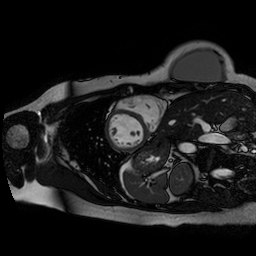

In [161]:
Image.open(images_path)

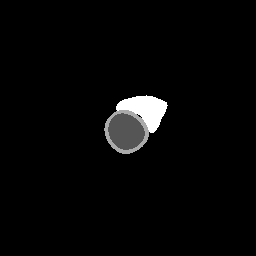

In [162]:
Image.open(mask_path)